In [18]:
import numpy as np

import keras
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.initializers import glorot_uniform
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.models import model_from_json

import pydot
import graphviz
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import pickle

from IPython.display import SVG
from keras.utils import np_utils 
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.utils.training_utils import multi_gpu_model

import matplotlib.pyplot as plt

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
from keras.utils import to_categorical
from keras import optimizers
from keras import regularizers


import tensorflow as tf
import os
os.environ["PATH"] += os.pathsep + '~/anaconda3/lib/bin/pydot/'
os.environ["PATH"] += os.pathsep + '~/anaconda3/lib/bin/graphviz/'

## Checking GPU settings

In [2]:
#LIsting available devices 

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5880965095158818871
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11286970368
locality {
  bus_id: 1
}
incarnation: 6682384220751552359
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [3]:
#Using AWS p2 instance with 1 gpu and 4 cpus 
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4},log_device_placement=True ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

## Loading data 

In [4]:
X_train = np.load('X_train.npy')
Y_train = np.load('Y_train.npy')
X_test = np.load('X_test.npy')
Y_test = np.load('Y_test.npy')

#One hot encoding Y 
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

print('Shape of X train: ',X_train.shape)
print('Shape of Y train: ',Y_train.shape)
print('Shape of X test: ',X_test.shape)
print('Shape of Y test: ',Y_test.shape)

Shape of X train:  (50000, 32, 32, 3)
Shape of Y train:  (50000, 10)
Shape of X test:  (10000, 32, 32, 3)
Shape of Y test:  (10000, 10)


## Building model

In [5]:
#Coursera deeplearning.ai specialization assignment code as completed and modified for resnet version 1

def identity_block(X, filters, stage, block):
    """
    Implementation of the identity block where the input skips over one convolutional layer
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (3, 3), strides = (1,1), padding = 'same', name = conv_name_base + '2a', kernel_initializer ='he_normal',kernel_regularizer=l2(1e-4))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (≈2 lines)
    X = Conv2D(filters = F2, kernel_size = (3, 3), strides = (1,1), padding = 'same', name = conv_name_base + '2c', kernel_initializer ='he_normal',kernel_regularizer=l2(1e-4))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    
    return X

In [6]:
#Coursera deeplearning.ai specialization assignment code as completed and modified for resnet version 1

def convolutional_block(X,filters, stage, block):
    """
    Implementation of the convolutional block in ResNet to reduce feature map size, increase number of filters
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (3, 3), strides = (2,2), name = conv_name_base + '2a',padding='same', kernel_initializer ='he_normal',kernel_regularizer=l2(1e-4))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈2 lines)
    X = Conv2D(F2, (3, 3), strides = (1,1), name = conv_name_base + '2c',padding='same', kernel_initializer ='he_normal',kernel_regularizer=l2(1e-4))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    #Shortcut path to match dimensions
    X_shortcut = Conv2D(F2, (1, 1), strides = (2,2), name = conv_name_base + '1',padding='same' ,kernel_initializer ='he_normal',kernel_regularizer=l2(1e-4))(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    return X

In [7]:
def ResNet_v1(input_shape = (32, 32, 3), classes = 10):
    """
    Implementation of the ResNet
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    X = X_input
    
    # Initial Convolutional layer
    X = Conv2D(16, (3, 3), strides = (1, 1), name = 'conv1', padding = 'same', kernel_initializer='he_normal',kernel_regularizer=l2(1e-4))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)

    # Stage 1 with three resnet blocks 
    X = identity_block(X,[16, 16], stage=1, block='a')
    X = identity_block(X, [16, 16], stage=1, block='b')
    X = identity_block(X, [16, 16], stage=1, block='c')

    # Stage 2 : 1 convolutional and 2 identity blocks
    X = convolutional_block(X, filters = [32, 32], stage = 2, block='a')
    X = identity_block(X, [32, 32], stage=2, block='b')
    X = identity_block(X, [32,32], stage=2, block='c')


    # Stage 3: 1 convolutional and 2 identity blocks
    X = convolutional_block(X, filters = [64, 64], stage = 3, block='a')
    X = identity_block(X, [64,64], stage=3, block='b')
    X = identity_block(X, [64,64], stage=3, block='c')
 

    # AVGPOOL
    X = AveragePooling2D(pool_size = (8,8), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer ='he_normal')(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet_v1')

    return model

In [8]:
#Number of gpus
n_gpu = 1

#Single GPU Training
if n_gpu <=1:
    model = ResNet_v1(input_shape = (32, 32, 3), classes = 10)

#Multi GPU Training
else:
    with tf.device("/device:CPU:0"):
        model = ResNet_v1(input_shape = (32, 32, 3), classes = 10)
        #Recommended so that the weights are stored and updated in
        #the CPU so as to avoid problems with weight sharing between GPUs 
   
    model = multi_gpu_model(model, gpus=n_gpu)
        
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 16)   64          conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
res1a_bran

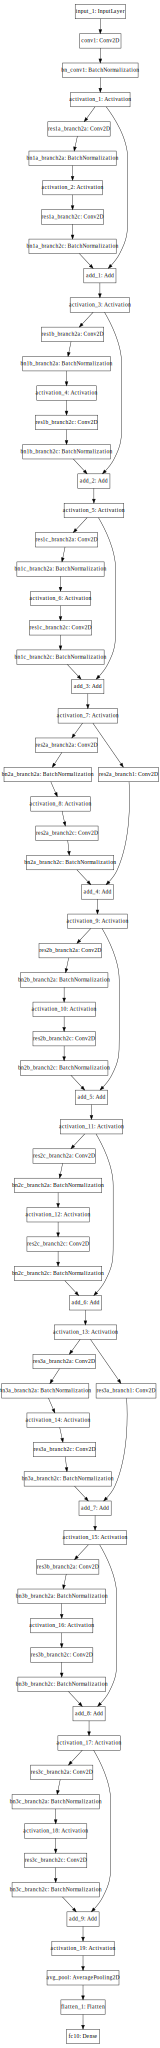

In [19]:
plot_model(model, to_file='resnetv1_model.png', show_shapes=True, show_layer_names=False)
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Callback function

This single callback function saves the loss history, validation and training accuracies, and implements learning rate decay after 80, 120, 160 and 180 epochs. The function also keeps track of validation accuracy in all the epochs and saves the model architecture and weights in an epoch to the disk if the validation accuracy in that epoch is better than the best validation accuracy obtained in any of the previous epochs. 

In [9]:
class MyCallbackFunction(keras.callbacks.Callback):

    def on_train_begin(self, logs={} ):
        #Learning rate schedule
        #Changed after 80,120,160,180 epochs 
        
        self.k = 0
        
        #Keeping track of number of epochs 
        self.epoch_n = 0 
        
        #Learning rates list
        self.lrs_in_epoch = [1e-4,1e-5,1e-6,1e-7]
        
        #History of losses and accuracies 
        self.loss = []
        self.val_acc =[]
        self.train_acc = []

        #monitoring improvement of validation accuracy 
        #Setting initial val acc to negative infinity 
        self.val_prev = -float("inf")
        
    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
      

    def on_epoch_end(self, epoch, logs):
        
        #Storing validation and training accuracies of the epoch
        self.val_acc.append(logs.get('val_acc'))
        self.train_acc.append(logs.get('acc'))

        #Incrementing number of epochs 
        self.epoch_n +=1
        
        #Saving model if val acc improves compared to best previous epoch
        if logs.get('val_acc') > self.val_prev: 
            print('Validation accuracy improved! Saving model. \n')
        
            #Saving model 
            json_string = model.to_json()
            with open('resnet_v1_models/model_epoch'+str(self.epoch_n)+'_json.pkl', 'wb') as m:
                pickle.dump(json_string, m)
            model.save_weights('resnet_v1_models/model_epoch'+str(self.epoch_n)+'_weights.h5')
            
            #Saving current better val acc to compare with next epoch's val acc
            self.val_prev = logs.get('val_acc')
            
        else: 
            print('Validation accuracy did not improve. Moving on. \n')
        
        #Printing learning rate 
        LR = K.get_value(self.model.optimizer.lr)
        print('Current learning rate: ',LR )

            
        #Adjusting learning rate     
        if self.epoch_n == 80 or self.epoch_n == 120 or self.epoch_n == 160 or self.epoch_n == 180:
            K.set_value(self.model.optimizer.lr,self.lrs_in_epoch[self.k])
            self.k+=1
    

#Main 

#Creating an instance of the callback function
history_cb = MyCallbackFunction()

## Compiling and fitting model 

Using adam optimizer, categorical cross-entropy as loss function and a batch size of 32. 

Real time data augmentation enabled.

Initial Learning rate:  0.001
Epoch 1/200
1563/1562 [==============================] - 74s 47ms/step - loss: 1.5092 - acc: 0.4952 - val_loss: 1.2819 - val_acc: 0.5885
Validation accuracy improved! Saving model. 

Current learning rate:  0.001
Epoch 2/200
1563/1562 [==============================] - 71s 45ms/step - loss: 1.1185 - acc: 0.6515 - val_loss: 1.0249 - val_acc: 0.6902
Validation accuracy improved! Saving model. 

Current learning rate:  0.001
Epoch 3/200
1563/1562 [==============================] - 71s 45ms/step - loss: 0.9693 - acc: 0.7118 - val_loss: 0.9156 - val_acc: 0.7359
Validation accuracy improved! Saving model. 

Current learning rate:  0.001
Epoch 4/200
1563/1562 [==============================] - 70s 45ms/step - loss: 0.8900 - acc: 0.7430 - val_loss: 0.8640 - val_acc: 0.7575
Validation accuracy improved! Saving model. 

Current learning rate:  0.001
Epoch 5/200
1563/1562 [==============================] - 70s 45ms/step - loss: 0

1563/1562 [==============================] - 70s 45ms/step - loss: 0.5384 - acc: 0.8849 - val_loss: 0.6348 - val_acc: 0.8598
Validation accuracy did not improve. Moving on. 

Current learning rate:  0.001
Epoch 40/200
1563/1562 [==============================] - 70s 45ms/step - loss: 0.5396 - acc: 0.8823 - val_loss: 0.6335 - val_acc: 0.8578
Validation accuracy did not improve. Moving on. 

Current learning rate:  0.001
Epoch 41/200
1563/1562 [==============================] - 70s 45ms/step - loss: 0.5354 - acc: 0.8847 - val_loss: 0.6188 - val_acc: 0.8637
Validation accuracy improved! Saving model. 

Current learning rate:  0.001
Epoch 42/200
1563/1562 [==============================] - 70s 45ms/step - loss: 0.5307 - acc: 0.8870 - val_loss: 0.6123 - val_acc: 0.8628
Validation accuracy did not improve. Moving on. 

Current learning rate:  0.001
Epoch 43/200
1563/1562 [==============================] - 70s 45ms/step - loss: 0.5373 - acc: 0.8858 - val_loss: 0.6326 - val_acc: 0.8549
Validat

1563/1562 [==============================] - 70s 45ms/step - loss: 0.4961 - acc: 0.8990 - val_loss: 0.6061 - val_acc: 0.8705
Validation accuracy did not improve. Moving on. 

Current learning rate:  0.001
Epoch 78/200
1563/1562 [==============================] - 71s 45ms/step - loss: 0.4924 - acc: 0.9015 - val_loss: 0.5867 - val_acc: 0.8713
Validation accuracy did not improve. Moving on. 

Current learning rate:  0.001
Epoch 79/200
1563/1562 [==============================] - 70s 45ms/step - loss: 0.4969 - acc: 0.8992 - val_loss: 0.6035 - val_acc: 0.8696
Validation accuracy did not improve. Moving on. 

Current learning rate:  0.001
Epoch 80/200
1563/1562 [==============================] - 70s 45ms/step - loss: 0.4949 - acc: 0.9004 - val_loss: 0.5935 - val_acc: 0.8717
Validation accuracy did not improve. Moving on. 

Current learning rate:  0.001
Epoch 81/200
1563/1562 [==============================] - 70s 45ms/step - loss: 0.4084 - acc: 0.9308 - val_loss: 0.5110 - val_acc: 0.8979
Val

1563/1562 [==============================] - 71s 45ms/step - loss: 0.2153 - acc: 0.9719 - val_loss: 0.4568 - val_acc: 0.9052
Validation accuracy did not improve. Moving on. 

Current learning rate:  1e-04
Epoch 116/200
1563/1562 [==============================] - 70s 45ms/step - loss: 0.2151 - acc: 0.9718 - val_loss: 0.4582 - val_acc: 0.9057
Validation accuracy did not improve. Moving on. 

Current learning rate:  1e-04
Epoch 117/200
1563/1562 [==============================] - 71s 45ms/step - loss: 0.2125 - acc: 0.9727 - val_loss: 0.4673 - val_acc: 0.9032
Validation accuracy did not improve. Moving on. 

Current learning rate:  1e-04
Epoch 118/200
1563/1562 [==============================] - 70s 45ms/step - loss: 0.2100 - acc: 0.9728 - val_loss: 0.4597 - val_acc: 0.9038
Validation accuracy did not improve. Moving on. 

Current learning rate:  1e-04
Epoch 119/200
1563/1562 [==============================] - 70s 45ms/step - loss: 0.2113 - acc: 0.9713 - val_loss: 0.4544 - val_acc: 0.9017

Validation accuracy did not improve. Moving on. 

Current learning rate:  1e-05
Epoch 153/200
1563/1562 [==============================] - 70s 45ms/step - loss: 0.1772 - acc: 0.9822 - val_loss: 0.4490 - val_acc: 0.9070
Validation accuracy did not improve. Moving on. 

Current learning rate:  1e-05
Epoch 154/200
1563/1562 [==============================] - 71s 45ms/step - loss: 0.1751 - acc: 0.9831 - val_loss: 0.4471 - val_acc: 0.9071
Validation accuracy did not improve. Moving on. 

Current learning rate:  1e-05
Epoch 155/200
1563/1562 [==============================] - 71s 45ms/step - loss: 0.1747 - acc: 0.9832 - val_loss: 0.4482 - val_acc: 0.9070
Validation accuracy did not improve. Moving on. 

Current learning rate:  1e-05
Epoch 156/200
1563/1562 [==============================] - 71s 45ms/step - loss: 0.1738 - acc: 0.9833 - val_loss: 0.4481 - val_acc: 0.9081
Validation accuracy did not improve. Moving on. 

Current learning rate:  1e-05
Epoch 157/200
1563/1562 [===================

1563/1562 [==============================] - 71s 45ms/step - loss: 0.1723 - acc: 0.9834 - val_loss: 0.4479 - val_acc: 0.9063
Validation accuracy did not improve. Moving on. 

Current learning rate:  1e-07
Epoch 191/200
1563/1562 [==============================] - 71s 45ms/step - loss: 0.1722 - acc: 0.9835 - val_loss: 0.4479 - val_acc: 0.9063
Validation accuracy did not improve. Moving on. 

Current learning rate:  1e-07
Epoch 192/200
1563/1562 [==============================] - 71s 45ms/step - loss: 0.1725 - acc: 0.9838 - val_loss: 0.4479 - val_acc: 0.9063
Validation accuracy did not improve. Moving on. 

Current learning rate:  1e-07
Epoch 193/200
1563/1562 [==============================] - 71s 45ms/step - loss: 0.1723 - acc: 0.9839 - val_loss: 0.4479 - val_acc: 0.9064
Validation accuracy did not improve. Moving on. 

Current learning rate:  1e-07
Epoch 194/200
1563/1562 [==============================] - 71s 45ms/step - loss: 0.1720 - acc: 0.9837 - val_loss: 0.4479 - val_acc: 0.9064

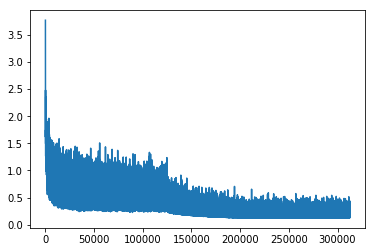

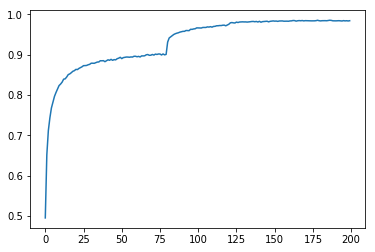

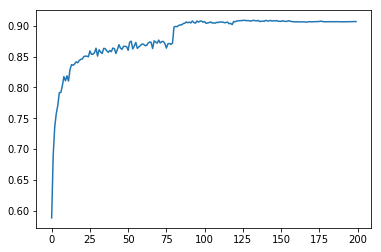

In [10]:
#Initial learning rate and optimizer
initial_rate = 0.001
opt = optimizers.Adam(lr=initial_rate)

#Compiling model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


#Data generator for training data  
#No data generator is used for testing data
data_generator = ImageDataGenerator(
                featurewise_center=False,
                samplewise_center = False,
                featurewise_std_normalization = False,
                samplewise_std_normalization=False,
                zca_whitening= False,
                rotation_range=0,
                width_shift_range=0.1,
                height_shift_range=0.1,
                horizontal_flip=True,
                vertical_flip=False,
                )

print('Real time data augmentation enabled.\n')
print('Initial Learning rate: ',initial_rate)

#Fitting model
model.fit_generator(data_generator.flow(X_train, Y_train, batch_size=32),
                    validation_data = (X_test, Y_test),
                    epochs = 200, 
                    steps_per_epoch = data_generator.flow(X_train,Y_train,batch_size=32).n/32,
                    callbacks = [history_cb])


#Model evaluation 
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

#Plotting loss and accuracies
plt.plot(history_cb.loss)
plt.show()

plt.plot(history_cb.train_acc)
plt.show()

plt.plot(history_cb.val_acc)
plt.show()

In [20]:
# best model reconstruction from JSON:
json_string = pickle.load( open( "aws_trained/model_epoch127_json.pkl", "rb" ) )
model = model_from_json(json_string)
model.load_weights('aws_trained/model_epoch127_weights.h5')

In [10]:
"""
Code from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 

"""
import sklearn
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Normalized confusion matrix
[[0.92 0.01 0.02 0.01 0.01 0.   0.   0.01 0.01 0.01]
 [0.   0.96 0.   0.   0.   0.   0.   0.   0.   0.03]
 [0.03 0.   0.88 0.02 0.03 0.02 0.02 0.01 0.01 0.  ]
 [0.01 0.   0.02 0.79 0.02 0.09 0.02 0.02 0.01 0.01]
 [0.01 0.   0.02 0.02 0.92 0.02 0.01 0.01 0.   0.  ]
 [0.01 0.   0.02 0.07 0.02 0.86 0.01 0.02 0.   0.  ]
 [0.01 0.   0.02 0.02 0.01 0.01 0.92 0.   0.   0.  ]
 [0.   0.   0.01 0.01 0.01 0.02 0.   0.94 0.   0.  ]
 [0.03 0.01 0.   0.   0.   0.   0.   0.   0.94 0.01]
 [0.01 0.02 0.   0.   0.   0.   0.   0.   0.01 0.95]]


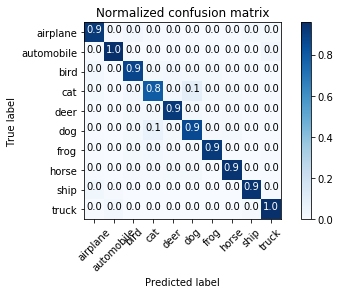

 Testing accuracy: 
0.9088


In [11]:
#Prediction test set 
p = model.predict(X_test)
#Converting from one hot back to integers
y_pred = [np.where(r==np.max(r))[0][0] for r in p]

#Ground truth
a = Y_test
#Converting from one hot back to integers
y_true = [np.where(r==1)[0][0] for r in a ]

#Caulculating confusion matrix 
cnf_matrix = confusion_matrix(y_true,y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'],normalize=True,
                      title='Normalized confusion matrix')

plt.show()


print(' Testing accuracy: ')
pr = model.predict(X_test)
ypred = [np.where(r==np.max(r))[0][0] for r in pr]
good = [1 for i in range(0,len(ypred)) if y_true[i]==ypred[i]]
accuracy = len(good)/len(ypred)
print(accuracy)